In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from scipy import signal
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
from pydub import AudioSegment
from pydub.playback import play
# Import math Library
import math
import os


pd.options.mode.chained_assignment = None

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (9, 12)


# 1 - Time to Frequency domain study

In [9]:
def plot_frequencies(filenames):
    for i in range(len(filenames)):
        freqs = convert_to_frequency(filenames[i])
        
        plt.subplot(len(filenames), 1, i+1)
        plt.plot(freqs[1], np.abs(freqs[2]), 'r')
        plt.xlabel("frequency, Hz")
        plt.ylabel("Amplitude, units")
        plt.title(filenames[i])

In [100]:
def convert_to_frequency(inp_filename):
    sampFreq, sound = wavfile.read(inp_filename)
    sound = sound / 2.0**15
    length_in_s = sound.shape[0] / sampFreq
    time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s
    signal = sound[:,0]
    
    fft_spectrum = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
    
    fft_spectrum_abs = np.abs(fft_spectrum)
    
    return fft_spectrum, freq, fft_spectrum_abs, sampFreq

def apply_filter_to_fft(freq, fft_spectrum, freq_filter):
        fft_abs = np.abs(fft_spectrum)
        max_abs_val = np.max(fft_abs)
        for i,f in enumerate(freq):
            if fft_abs[i] < max_abs_val / 2:
                fft_spectrum[i] = np.round(fft_spectrum[i] * ((4 / (0.0002 * (i+1)))+4))
            if fft_abs[i] >= max_abs_val / 2:
                fft_spectrum[i] = 0
                
            if f < 62 and f > 58:
                fft_spectrum[i] = 0.0
            if f < 21 or f > 20000:
                fft_spectrum[i] = 0.0

            fft_spectrum[i] *= 3
        return fft_spectrum
            
def revert_to_wav(filename, fft_spectrum, sampFreq):
    noiseless_signal = np.fft.irfft(fft_spectrum)
    wavfile.write(filename, sampFreq, noiseless_signal)
    

def boost_audio(inp_filename, original_filename, out_filename, freq_filter):
    print("Converting to fft")
    sample = convert_to_frequency(inp_filename)
    original = convert_to_frequency(original_filename)
    
    
    print("Creating filter", len(sample[0]))
    freq_filter = create_filter(sample[2])
    
    print("Filtering")
    fft_spectrum = apply_filter_to_fft(sample[1], sample[0], freq_filter)
    # For more on the scipy.signal API: https://docs.scipy.org/doc/scipy/reference/signal.html#window-functions
    #fft_spectrum = signal.fftconvolve(fft_spectrum, signal.windows.gaussian(50, 8), mode='same')
    
    print("plotting")
    plt.subplot(4,1,2)
    plt.plot(sample[1], np.abs(sample[2]), 'r')
    plt.subplot(4,1,2)
    plt.plot(sample[1], freq_filter, 'y')
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.subplot(4,1,3)
    plt.plot(original[1], np.abs(original[2]), 'b')
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.tight_layout()
    plt.subplot(4,1,4)
    plt.plot(sample[1], np.abs(fft_spectrum), 'g')
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.tight_layout()
    plt.show()
    
    revert_to_wav(out_filename, fft_spectrum, sample[3])

In [103]:
def create_filter(fft_spectrum):
    freq_filter = np.arange(len(fft_spectrum))
    #for i in range(len(freq_filter)):
    #    freq_filter[i] =  80.0 / (float(i+1)*0.1)
        
    freq_filter[:2200] = 8
    freq_filter[2200:12000] = 4
    freq_filter[12000:30000] = 2.5
    freq_filter[30000:65000] = 1.5
    freq_filter[65000:] = 1
        
    return freq_filter

In [124]:
freq_filter = np.arange(229377)
freq_filter[:2100] = 2
freq_filter[2100:6000] = 1
freq_filter[6000:10000] = 0.
freq_filter[10000:16000] = 30.0
freq_filter[14000:25000] = 17.0
freq_filter[25000:45000] = 10.0
freq_filter[45000:65000] = 7.0
freq_filter[65000:] = 5.0

print(freq_filter.shape)

conv_freq_filter = np.array([7, 26, 41, 26, 7])

(229377,)


In [136]:
np.sum((conv_freq_filter+0j) * (np.array([7/107, 26/107, 41/107, 26/107, 7/107])+1j))

(29.261682242990656+107j)

Text(0, 0.5, 'Amplitude, units')

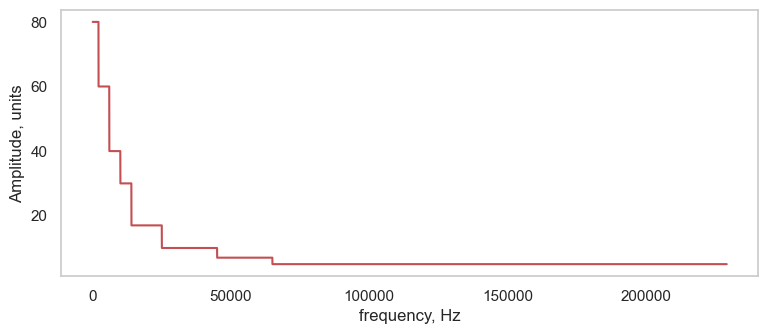

In [322]:
plt.subplot(3,1,1)
plt.plot(freq_filter, 'r')
plt.xlabel("frequency, Hz")

plt.ylabel("Amplitude, units")

Converting to fft
Creating filter 240129
(240129,) [8 8 8 ... 1 1 1] 1
Filtering


<ipython-input-394-eec78af3fbf5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


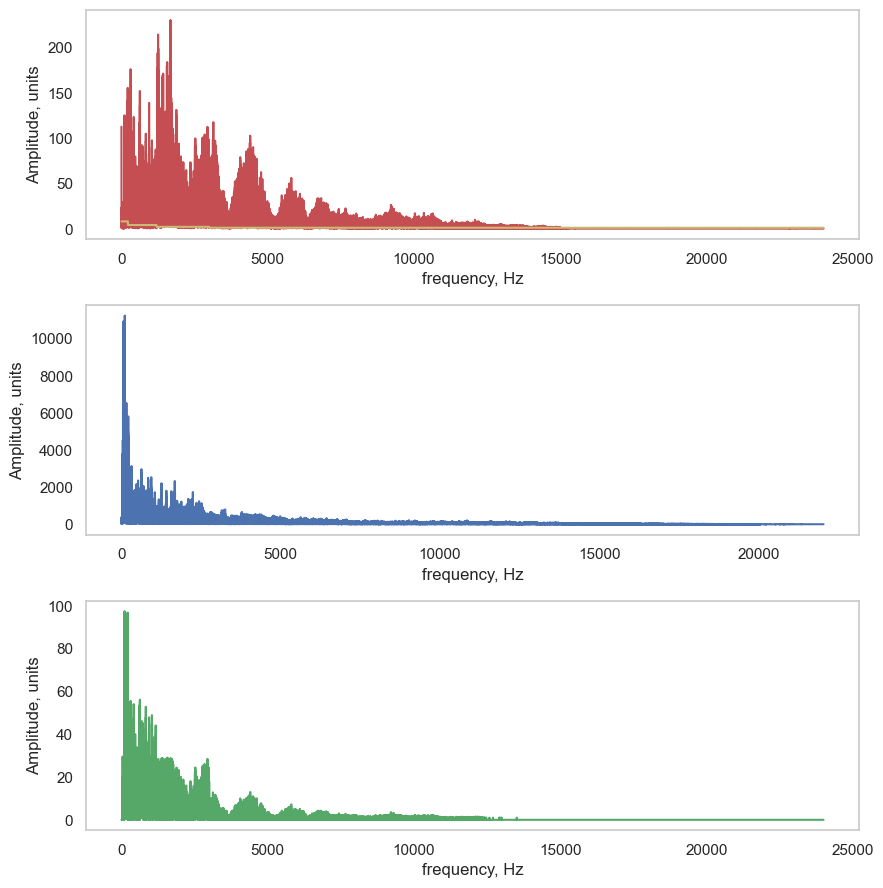

In [401]:
boost_audio('data/sample_1.wav', 'data/cut_original.wav', 'data/noiseless_sample_boosted1.wav', freq_filter)

Converting to fft
Creating filter 240641
(240641,) [8 8 8 ... 1 1 1] 1
Filtering


<ipython-input-394-eec78af3fbf5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


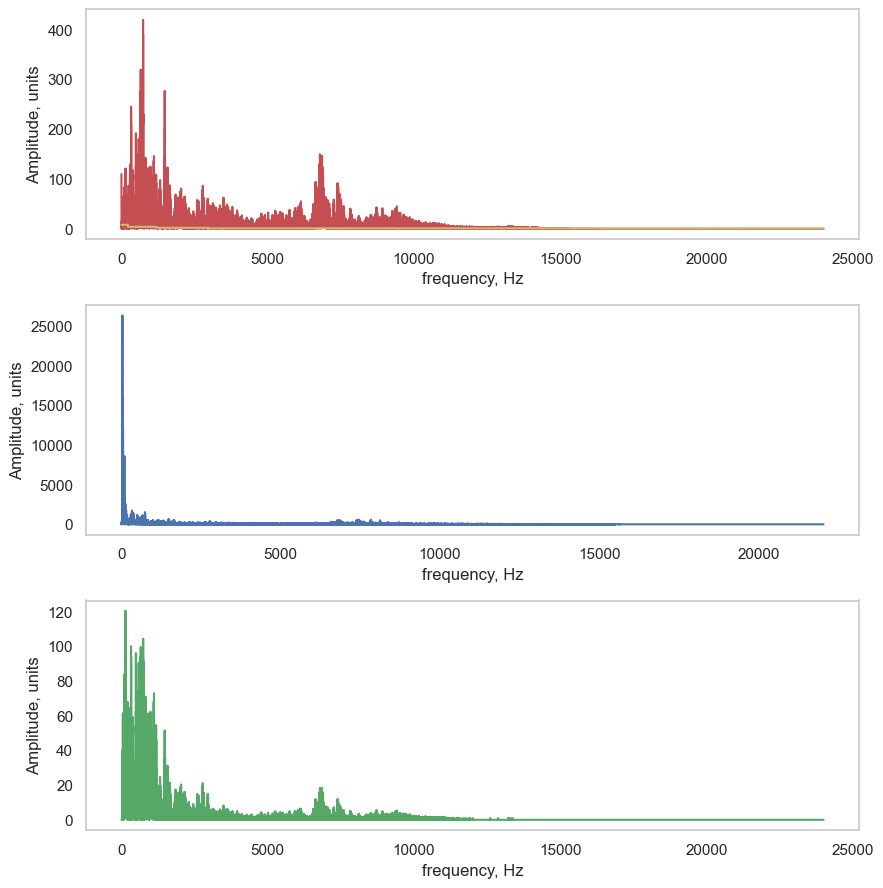

In [406]:
boost_audio('data/sample_2.wav', 'data/cut_original2.wav', 'data/noiseless_sample2_boosted1.wav', conv_freq_filter)

Converting to fft
Creating filter 229377
(229377,) [8 8 8 ... 1 1 1] 1
Filtering


<ipython-input-394-eec78af3fbf5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


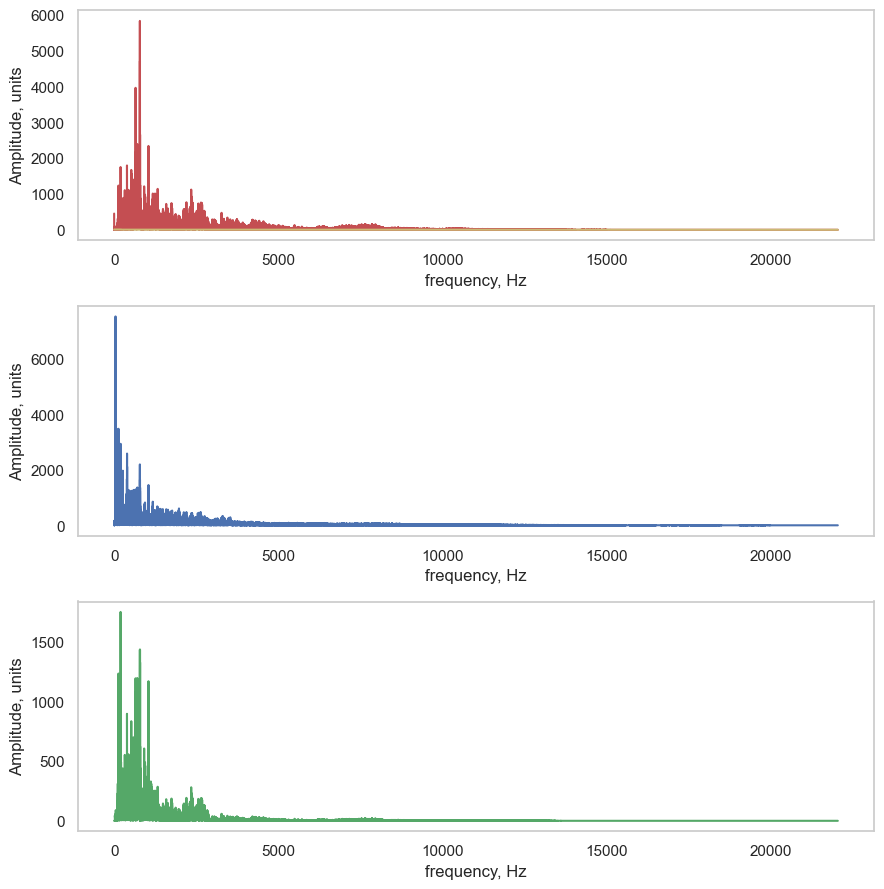

In [407]:
boost_audio('data/sample_3.wav', 'data/cut_original3.wav', 'data/noiseless_sample3_boosted1.wav', conv_freq_filter)

Converting to fft
Creating filter 229377
(229377,) [8 8 8 ... 1 1 1] 1
Filtering


<ipython-input-394-eec78af3fbf5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


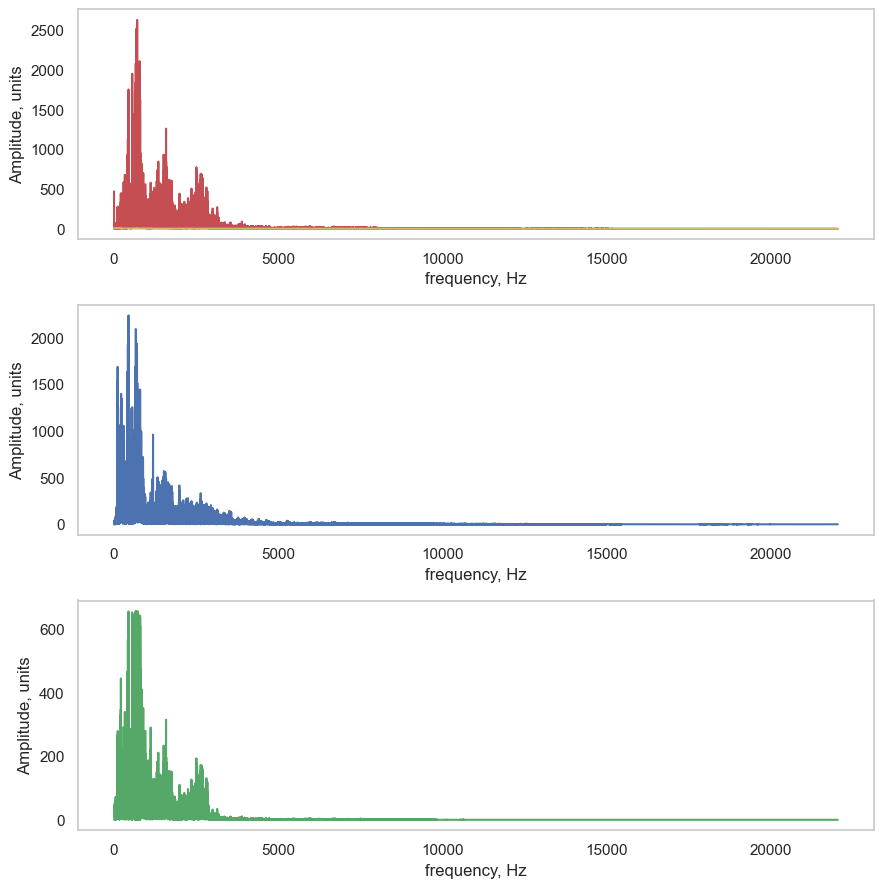

In [408]:
boost_audio('data/sample_4.wav', 'data/cut_original4.wav', 'data/noiseless_sample4_boosted1.wav', conv_freq_filter)

Converting to fft
Creating filter 229377
Filtering


<ipython-input-100-3bfdc2500c98>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


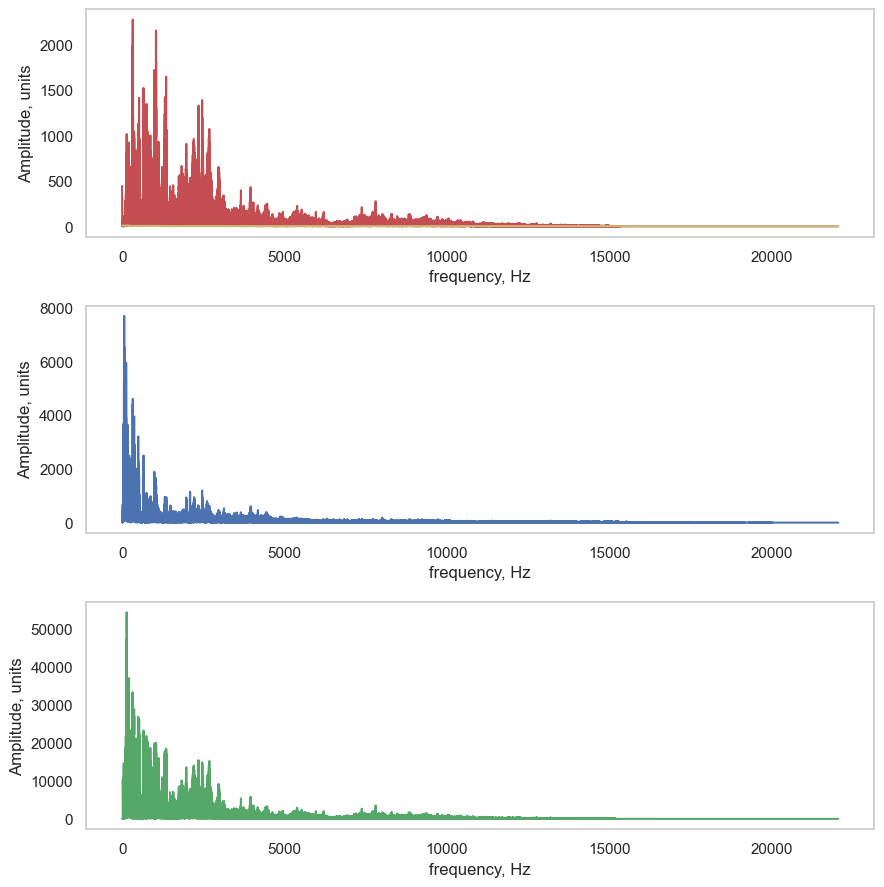

In [104]:
boost_audio('data/sample_5.wav', 'data/cut_original5.wav', 'data/noiseless_sample5_boosted1.wav', None)

<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)
<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)
<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)
<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)
<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


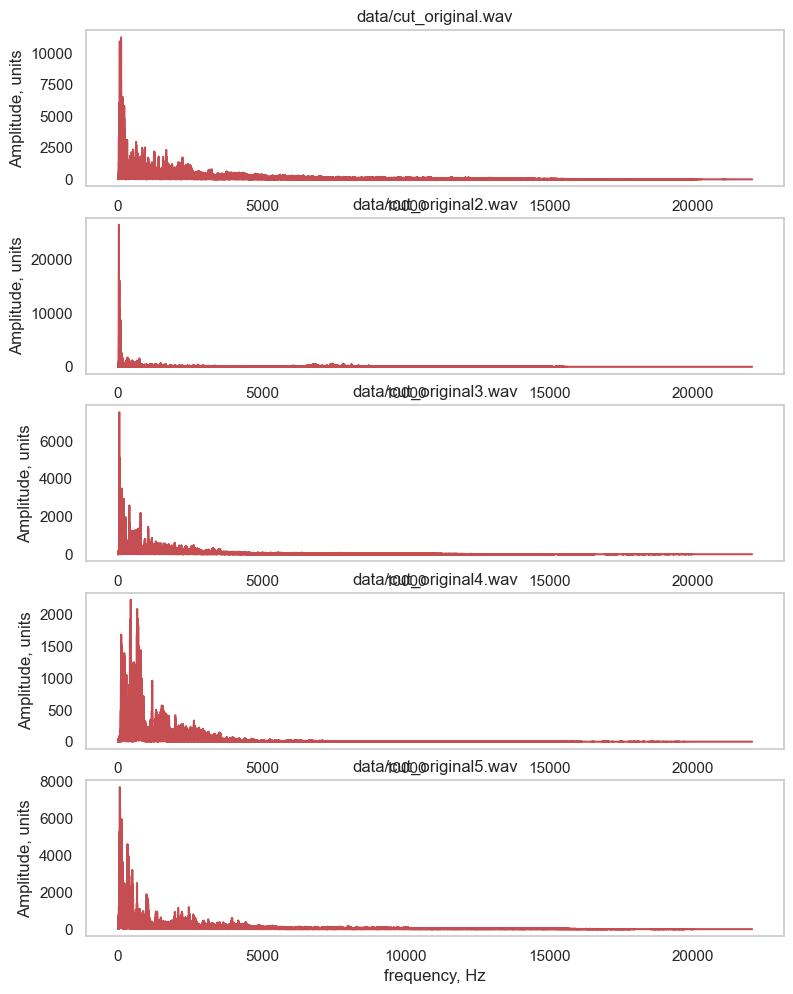

In [261]:
plot_frequencies(['data/cut_original.wav', 'data/cut_original2.wav', 'data/cut_original3.wav', 'data/cut_original4.wav', 'data/cut_original5.wav'])
                  

# 2 - Apply recorded filter to audio file

In [85]:
def convert_to_frequency(inp_filename):
    sampFreq, sound = wavfile.read(inp_filename)
    sound = sound / 2.0**15
    length_in_s = sound.shape[0] / sampFreq
    time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s
    signal = sound[:,0]
    
    fft_spectrum = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
    
    fft_spectrum_abs = np.abs(fft_spectrum)
    
    return fft_spectrum, freq, fft_spectrum_abs, sampFreq

def filter_signal(i):
    return (((i+1) * 0.02)**2)

def gaussian_filter_signal(i):
    #if(i+1 < 30000):
    #    return 0.05
    
    #if(i+1 >= 30000 and i+1 < 50000):
    #    return 3000 + (i+1) * 40/20000
    
    if(i+1 < 10000): return (200/10000)*(i+1)
    
    return 100+ 10*math.exp(-(((((i+1)-5000)**2)/(2*500**2))))

def apply_filter_to_fft2(freq, fft_spectrum):
    fft_abs = np.abs(fft_spectrum)
    #print(fft_abs[0])
    max_abs_val = np.max(fft_abs)
    for i,f in enumerate(freq):
        if fft_abs[i] > max_abs_val / 5 and f < 1000:
            fft_spectrum[i] /= 5
        elif fft_abs[i] > max_abs_val / 3:
            fft_spectrum[i] /= 3
        else:
            fft_spectrum[i] = fft_spectrum[i] * gaussian_filter_signal(i)
        #if fft_abs[i] >= max_abs_val / 2:
        #    fft_spectrum[i] = 0

        if f < 62 and f > 58:
            fft_spectrum[i] = 0.0
        if f < 21 or f > 20000:
            fft_spectrum[i] = 0.0

        fft_spectrum[i] /= 1e2
    return fft_spectrum


def revert_to_wav(filename, fft_spectrum, sampFreq):
    noiseless_signal = np.fft.irfft(fft_spectrum)
    wavfile.write(filename, sampFreq, noiseless_signal)
    

def filter_audio(inp_filename, original_filename, out_filename):
    print("Converting to fft")
    sample = convert_to_frequency(inp_filename)
    #print(sample)
    original = convert_to_frequency(original_filename)
    
    
    print("Creating filter", len(sample[0]))
    #freq_filter = create_filter(sample[2])
    #freq_filter = []
    #for i in range(len(sample[1])):
    #    freq_filter.append(filter_signal(i))
    
    print("Filtering")
    fft_spectrum = sample[0]
    #fft_spectrum = signal.fftconvolve(fft_spectrum, signal.windows.gaussian(50, 8), mode='same')
    #fft_spectrum = signal.fftconvolve(fft_spectrum, signal.windows.gaussian(50, 8), mode='same')
    fft_spectrum = apply_filter_to_fft2(sample[1], fft_spectrum)

    #fft_spectrum = signal.fftconvolve(fft_spectrum, signal.windows.gaussian(50, 8), mode='same')
    #fft_spectrum = signal.fftconvolve(fft_spectrum, signal.windows.gaussian(50, 8), mode='same')
    # For more on the scipy.signal API: https://docs.scipy.org/doc/scipy/reference/signal.html#window-functions
    
    
    print("plotting")
    plt.subplot(4,1,2)
    plt.plot(sample[1], np.abs(sample[2]), 'r')
    #plt.subplot(4,1,2)
    #plt.plot(freq_filter, np.abs(sample[2]), 'b')
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.subplot(4,1,3)
    plt.plot(original[1], np.abs(original[2]), 'b')
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.tight_layout()
    plt.subplot(4,1,4)
    plt.plot(sample[1], np.abs(fft_spectrum), 'g')
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.tight_layout()
    plt.show()
    
    revert_to_wav(out_filename, fft_spectrum, sample[3])

Converting to fft
Creating filter 240001
Filtering
plotting


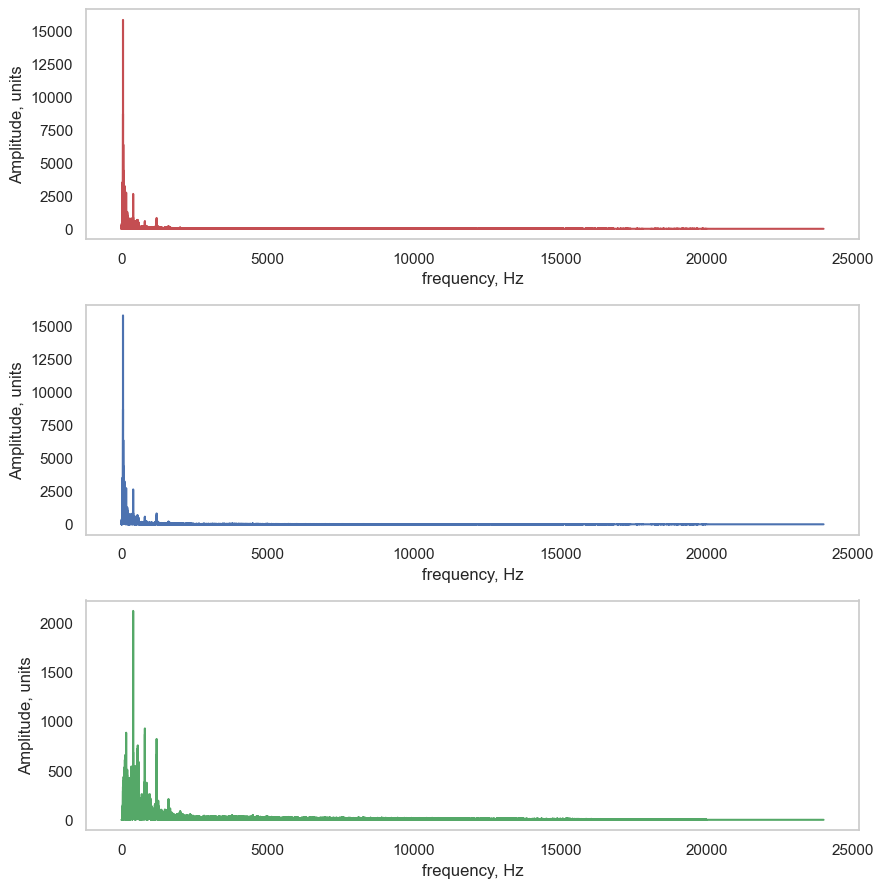

In [106]:
filter_audio(
    '/Volumes/Seagate/Coding/Datasets/music-classifier/sampled/blues/unf-0_blues_mix_2.wav',
    '/Volumes/Seagate/Coding/Datasets/music-classifier/sampled/blues/unf-0_blues_mix_2.wav',
    '/Volumes/Seagate/Coding/Datasets/music-classifier/sampled/blues/0_blues_mix_2___9.wav')

Converting to fft
Creating filter 229377
Filtering


<ipython-input-85-0cdfaaedb9cc>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


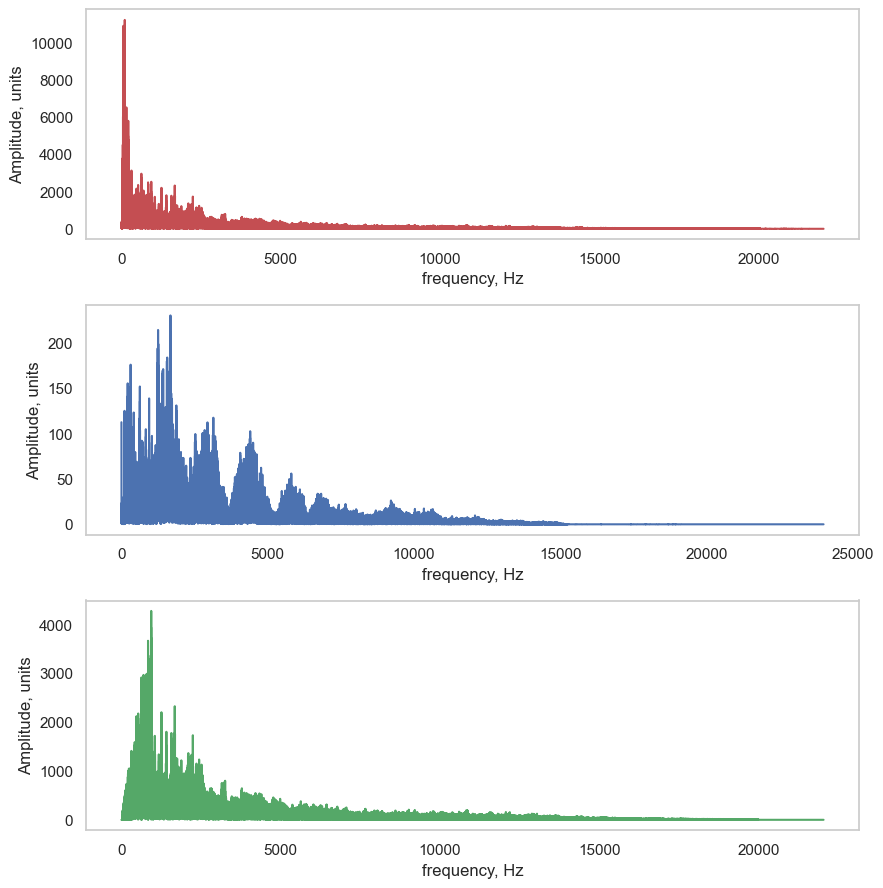

In [88]:
filter_audio('data/cut_original.wav', 'data/sample_1.wav', 'data/noiseful_sample1_12.wav')

Converting to fft
Creating filter 229377
Filtering


<ipython-input-85-0cdfaaedb9cc>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


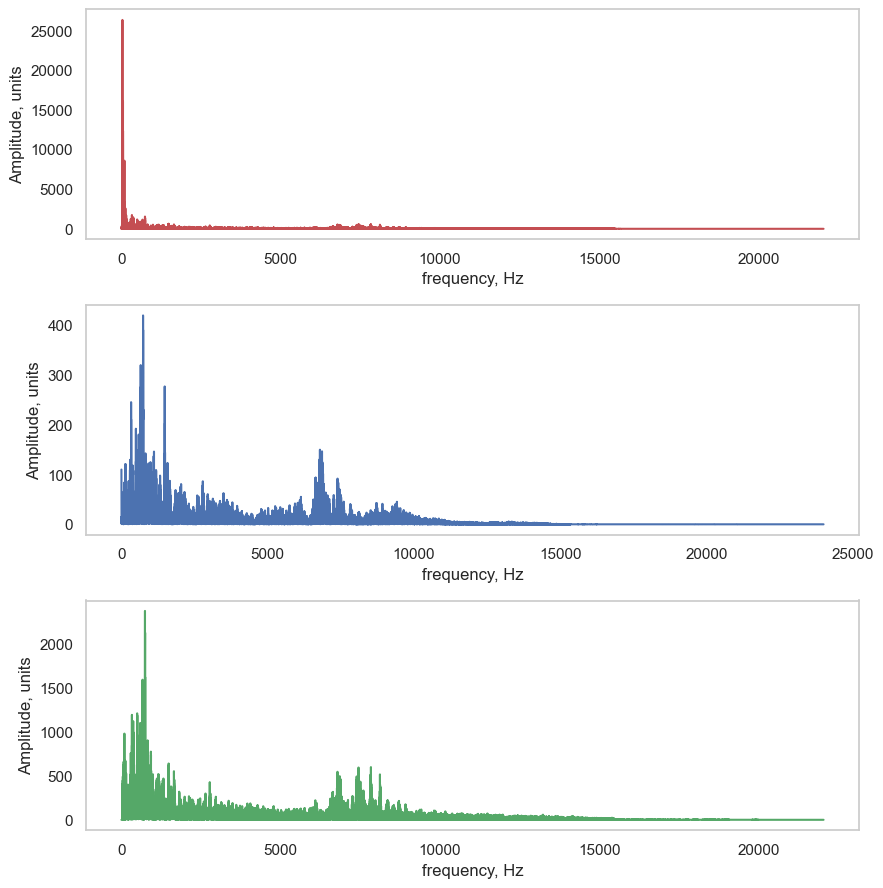

In [89]:
filter_audio('data/cut_original2.wav', 'data/sample_2.wav', 'data/noiseful_sample2_7.wav')

Converting to fft
Creating filter 229377
Filtering


<ipython-input-85-0cdfaaedb9cc>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


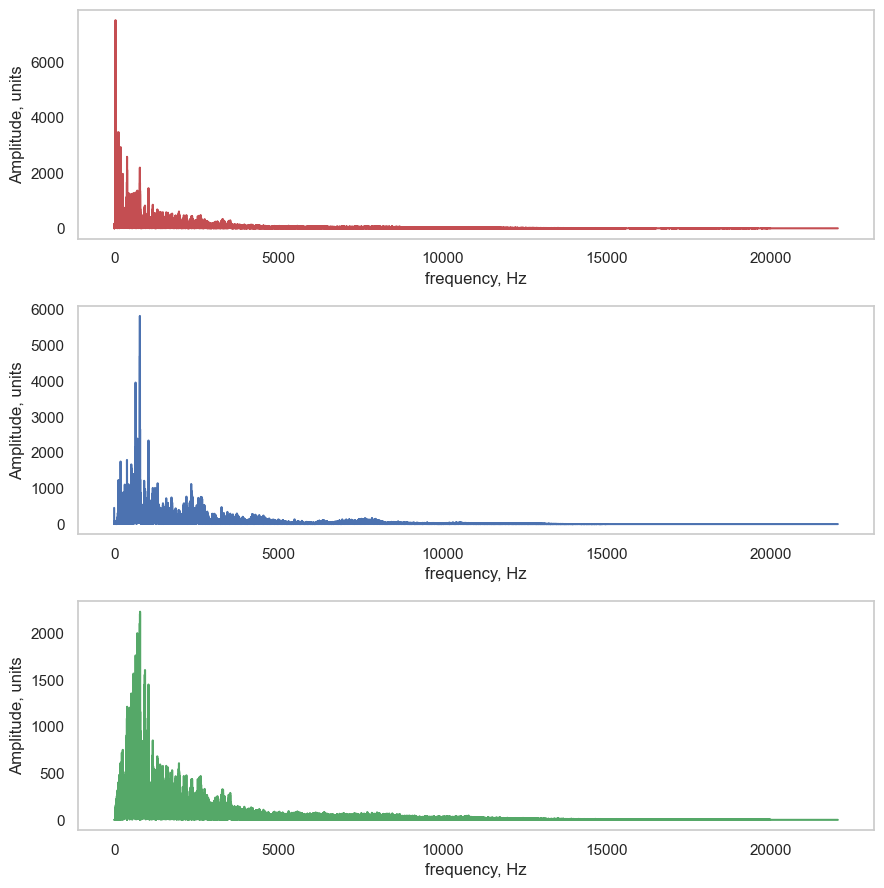

In [90]:
filter_audio('data/cut_original3.wav', 'data/sample_3.wav', 'data/noiseful_sample3_4.wav')

Converting to fft
Creating filter 229377
Filtering


<ipython-input-85-0cdfaaedb9cc>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


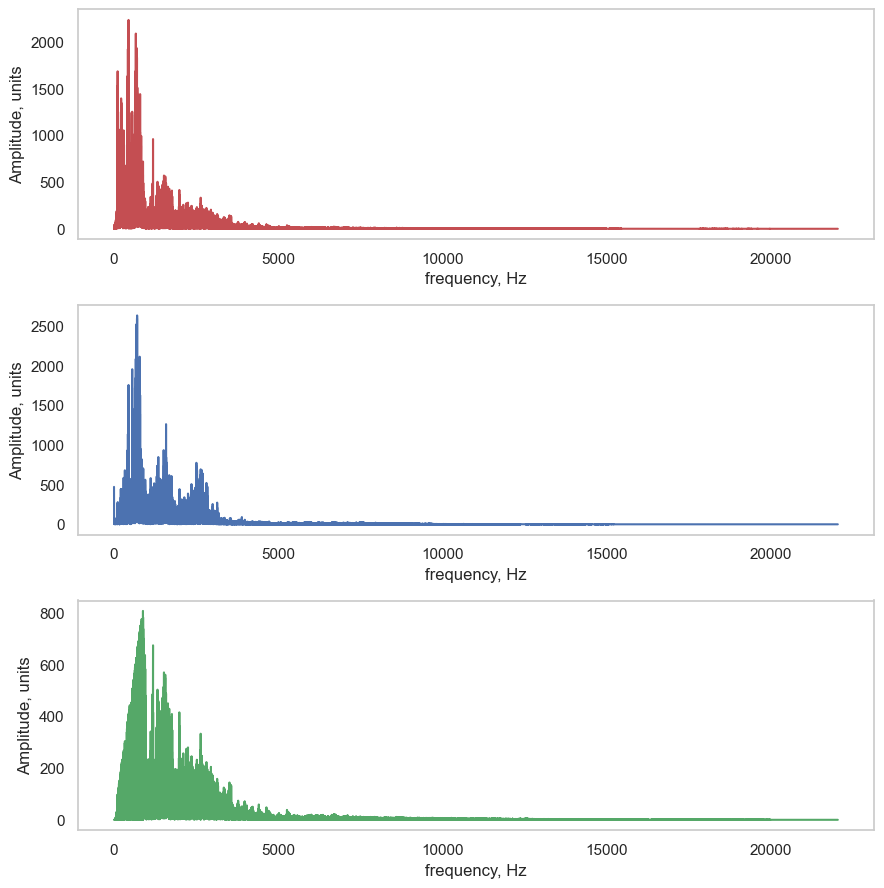

In [91]:
filter_audio('data/cut_original4.wav', 'data/sample_4.wav', 'data/noiseful_sample4_3.wav')

Converting to fft
Creating filter 229377
Filtering


<ipython-input-85-0cdfaaedb9cc>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


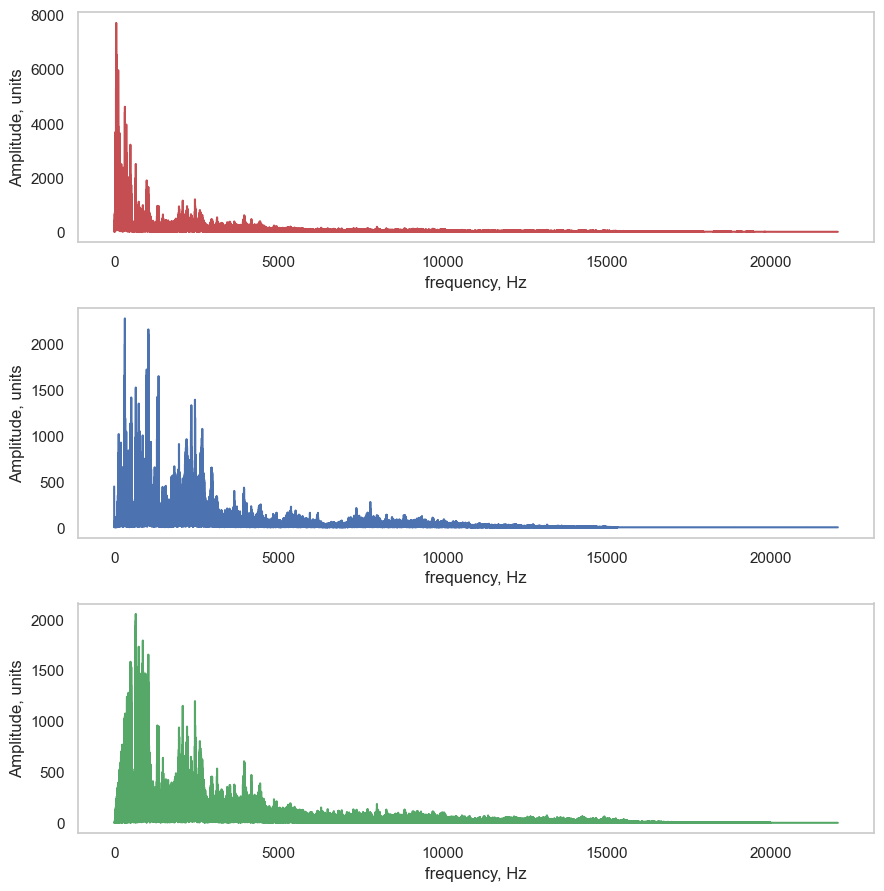

In [92]:
filter_audio('data/cut_original5.wav', 'data/sample_5.wav', 'data/noiseful_sample5_4.wav')

Converting to fft


<ipython-input-104-bf348c5ac987>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


Creating filter 17385710
Filtering
plotting


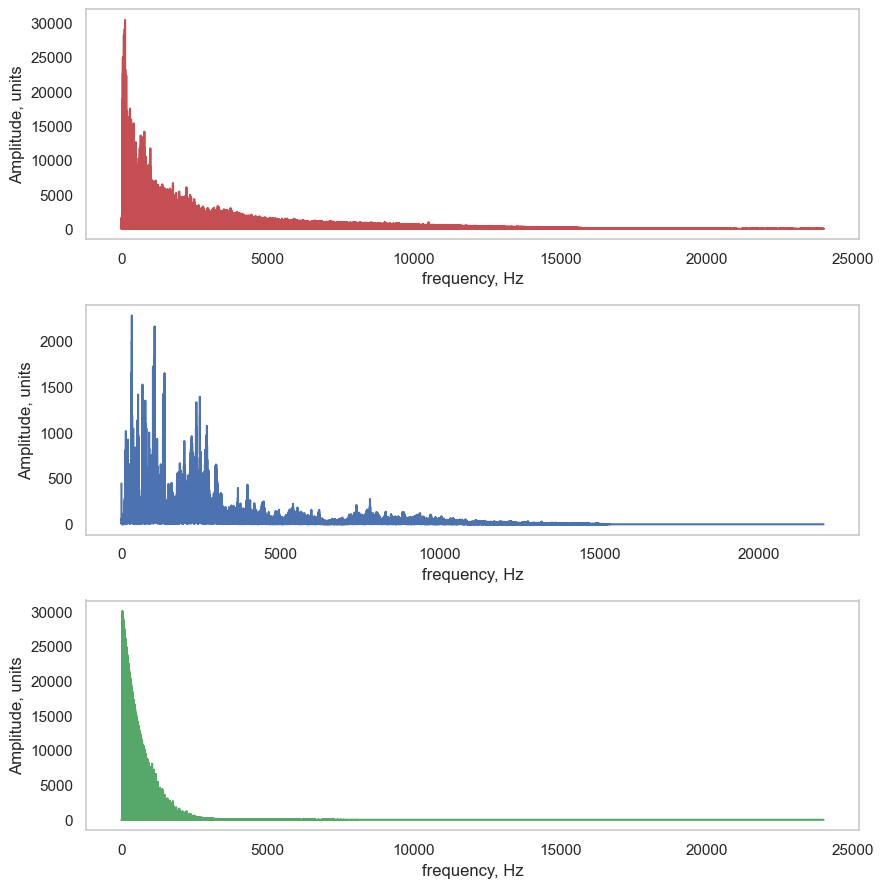

In [110]:
filter_audio('data/genres_original_2/rock/rock_mix_1.wav', 'data/sample_5.wav', 'data/genres_original_2/rock/rock_mix_1_filtered.wav')

In [107]:

def convert_to_frequency(inp_filename):
    sampFreq, sound = wavfile.read(inp_filename)
    sound = sound / 2.0**15
    length_in_s = sound.shape[0] / sampFreq
    time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s
    signal = sound[:,0]
    
    fft_spectrum = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
    
    fft_spectrum_abs = np.abs(fft_spectrum)
    
    return fft_spectrum, freq, fft_spectrum_abs, sampFreq

def filter_signal(i):
    return (((i+1) * 0.02)**2)

def gaussian_filter_signal(i):
    
    if(i+1 < 10000): return (200/10000)*(i+1)
    
    return 100+ 10*math.exp(-(((((i+1)-5000)**2)/(2*500**2))))

def apply_filter_to_fft2(freq, fft_spectrum):
    fft_abs = np.abs(fft_spectrum)
    #print(fft_abs[0])
    max_abs_val = np.max(fft_abs)
    for i,f in enumerate(freq):
        if fft_abs[i] > max_abs_val / 5 and f < 1000:
            fft_spectrum[i] /= 5
        elif fft_abs[i] > max_abs_val / 3:
            fft_spectrum[i] /= 3
        else:
            fft_spectrum[i] = fft_spectrum[i] * gaussian_filter_signal(i)
        #if fft_abs[i] >= max_abs_val / 2:
        #    fft_spectrum[i] = 0

        if f < 62 and f > 58:
            fft_spectrum[i] = 0.0
        if f < 21 or f > 20000:
            fft_spectrum[i] = 0.0

        fft_spectrum[i] /= 1e2
    return fft_spectrum


def revert_to_wav(filename, fft_spectrum, sampFreq):
    noiseless_signal = np.fft.irfft(fft_spectrum)
    wavfile.write(filename, sampFreq, noiseless_signal)
    

def prod_filter_audio(inp_filename, out_filename):
    sample = convert_to_frequency(inp_filename)
    fft_spectrum = apply_filter_to_fft2(sample[1], sample[0])
    revert_to_wav(out_filename, fft_spectrum, sample[3])


In [111]:

for d in os.walk('/Volumes/Seagate/Coding/Datasets/music-classifier/unsampled/'):
    curr_genre = d[0].split('/')[-1]

    if curr_genre == '': continue

    for clip in d[2]:
        clip_path = d[0] + '/' + clip
        print(clip_path, clip)

        if clip == '.DS_Store': continue

        sound = AudioSegment.from_file(clip_path)

        curr_point = 0
        prev_point = -1

        # for i in range(10):
        i = 0
        while prev_point < len(sound):
            prev_point = curr_point
            curr_point += 10000

            if prev_point >= len(sound): break

            if curr_point > len(sound) and len(sound) - prev_point >= 8000:
                sample = sound[prev_point:len(sound)]
            elif curr_point < len(sound):
                sample = sound[prev_point:curr_point]
            else:
                break

            sample.export(
                '/Volumes/Seagate/Coding/Datasets/music-classifier/sampled/' + curr_genre + '/unf-' + str(i) + '_' + clip,
                format="wav")

            #prod_filter_audio('/Volumes/Seagate/Coding/Datasets/music-classifier/sampled/' + curr_genre + '/unf-' + str(i) + '_' + clip,
            #    '/Volumes/Seagate/Coding/Datasets/music-classifier/sampled/' + curr_genre + '/' + str(i) + '_' + clip)

            #os.remove('/Volumes/Seagate/Coding/Datasets/music-classifier/sampled/' + curr_genre + '/unf-' + str(i) + '_' + clip)

            i += 1
    
    print(d[0])

/Volumes/Seagate/Coding/Datasets/music-classifier/unsampled/blues/blues_mix_2.wav blues_mix_2.wav
/Volumes/Seagate/Coding/Datasets/music-classifier/unsampled/blues/._blues_mix_2.wav ._blues_mix_2.wav


CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.3)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  9.100 /  5.  9.100
  libswresample   3.  9.100 /  3.  9.100
  libpostproc    55.  9.100 / 55.  9.100
/Volumes/Seagate/Coding/Datasets/music-classifier/unsampled/blues/._blues_mix_2.wav: Invalid data found when processing input
